This notebook aims to find a way how the Cls can be smoothed according to an angle (FWHM) consistent with `healpy.sphtfunc.smoothalm`

In [1]:
import os, h5py
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from msfm.utils import scales, cross_statistics
from msi.utils import input_output

24-02-02 11:51:43   imports.py INF   Setting up healpy to run on 10 CPUs 


In [2]:
indices, names = cross_statistics.get_cross_bin_indices(
    with_lensing=True,
    with_clustering=False,
    with_cross_z=False,
    with_cross_probe=False,
)
print(indices, names)

[0, 8, 15, 21] ['bin_0x0' 'bin_1x1' 'bin_2x2' 'bin_3x3']


In [3]:
n_side = 512
l_max = 3 * n_side - 1
fwhm_arcmin = 30.0
fwhm = scales.arcmin_to_rad(fwhm_arcmin)

l_naive_smooth = scales.angle_to_ell(fwhm, arcmin=False, method="naive")
print(f"Naive smoothig scale: {l_naive_smooth}")

Naive smoothig scale: 360.0


In [4]:
# load some non-smoothed Cls
with h5py.File("/Users/arne/data/DESY3/cls/v7/fiducial_cls.h5", "r") as f:
    raw_cls = f["cls/raw"][0, :, 21]

print(raw_cls.shape)

# toy version
# raw_cls = np.arange(1, l_max+1)**-3.0

(1536,)


In [5]:
# roundabout way of using healpy to smooth the Cls
example_map = hp.synfast(cls=raw_cls, nside=n_side)
example_map = hp.smoothing(example_map, fwhm=fwhm)
healpy_smoothed_cls = hp.anafast(example_map)

print(healpy_smoothed_cls.shape)

(1536,)


In [8]:
healpy_smoothed_cls

array([3.15250228e-19, 3.64892405e-19, 3.15241226e-19, ...,
       7.60228042e-20, 6.28733715e-20, 7.54168779e-20])

In [9]:
my_smoothed_cls

array([0.00000000e+00, 1.49575811e-35, 3.73721168e-34, ...,
       7.38688104e-24, 6.13341562e-24, 4.38407758e-24])

(1536,)


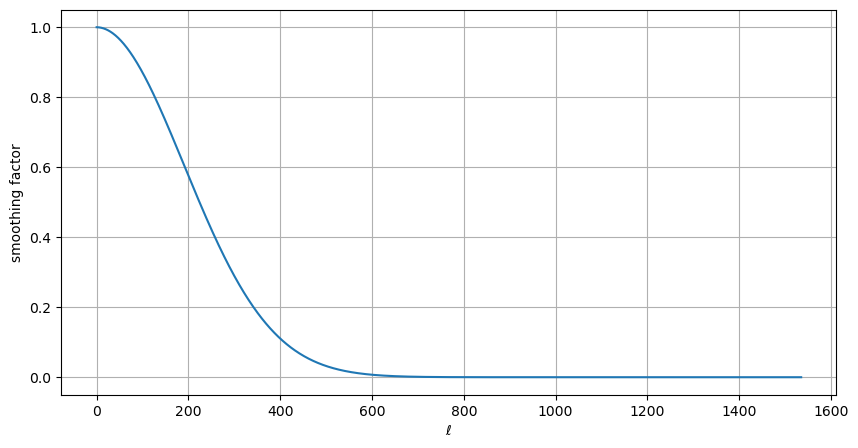

In [6]:
# from https://github.com/healpy/healpy/blob/be5d47b0720d2de69d422f661d75cd3577327d5a/healpy/sphtfunc.py#L974C13-L975C1
sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
ell = np.arange(l_max + 1)
# extra square because we're smoothing Cls, not alms
fact = np.exp(-0.5 * ell * (ell + 1) * sigma ** 2)**2

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(fact, label='raw')
ax.set(xlabel=r"$\ell$", ylabel="smoothing factor")
ax.grid(True)

my_smoothed_cls = fact * raw_cls

print(my_smoothed_cls.shape)

# results

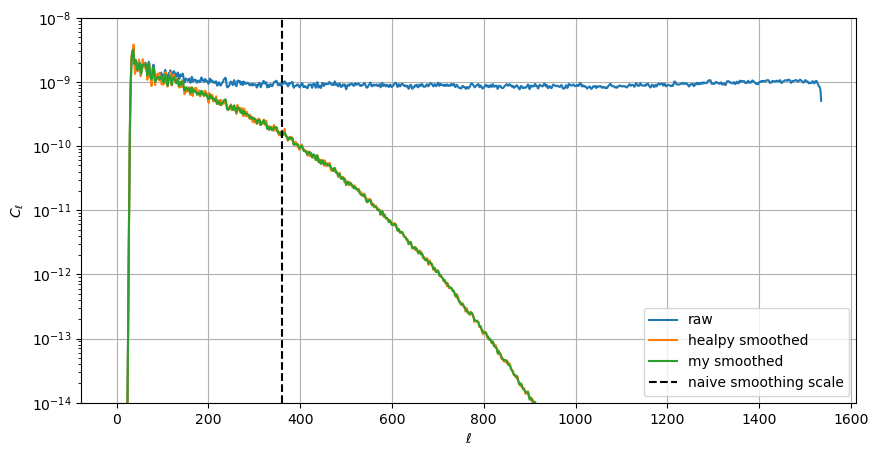

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(raw_cls, label='raw')
ax.plot(healpy_smoothed_cls, label='healpy smoothed')
ax.plot(my_smoothed_cls, label='my smoothed')
ax.axvline(l_naive_smooth, color='k', linestyle='--', label='naive smoothing scale')
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", xscale="linear", yscale="log", ylim=(1e-14,1e-8))#, xlim=(0, 2*l_naive_smooth))
ax.legend()
ax.grid(True)

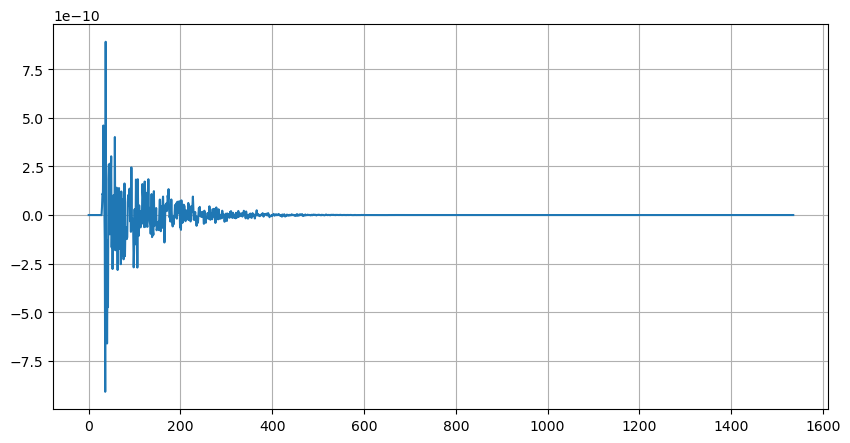

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(healpy_smoothed_cls - my_smoothed_cls, label='raw')
ax.grid(True)